In [1]:
%run setup.py

from scipy.optimize import curve_fit
from grid import match_modes

# Get systematic uncertainties for the models

In [2]:
stars = pd.read_excel('sample/samples.xlsx')
idx = (stars['ifmodelling']==1) #& (stars['numax']>0) &  (stars['Dnu']>2) &
       #(stars['[M/H]']>-3.) & (stars['Teff']>0) & (stars['lum_J']>0) 

stars = stars.loc[idx,:].reset_index(drop=True)
modes = pd.read_excel('sample/modes.xlsx')

In [3]:
def multi(inputs):
    istar, star = inputs
    filepath = 'results_spec_gaia_nu/{:0.0f}/data.h5'.format(star['KIC'])
    if not os.path.exists(filepath): return [np.nan]
    f = h5py.File(filepath,'r')

    idx = (modes['KIC']==star['KIC']) 
    tm = modes.loc[idx,:].reset_index(drop=True)
    
    idx = np.argmin(f['chi2_seismic_l0'][:])
    mod_freq = f['mod_freq_sc'][idx, (tm['l']==0).to_numpy()]
    obs_freq = tm.loc[tm['l']==0,'fc'].to_numpy()
    rms_l0 = np.sqrt(np.mean((mod_freq - obs_freq)**2))
    
    return [rms_l0]

r=process_map(multi, stars.iterrows(), total=len(stars), max_workers=12)

  0%|          | 0/1294 [00:00<?, ?it/s]

In [92]:
stars.loc[:,'rms'] = np.array(r)

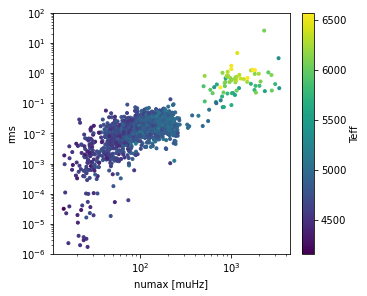

In [93]:
fig, axes = plt.subplots(figsize=[5,4], nrows=1, ncols=1, squeeze=False, constrained_layout=True)
axes = axes.reshape(-1)

c=axes[0].scatter(stars['numax'], stars['rms'], marker='.', c=stars['Teff'])

for iax in range(1):
    axes[iax].set_yscale('log')
    axes[iax].set_xscale('log')
    axes[iax].set_xlabel('numax [muHz]')
    axes[iax].set_ylim(10.**-6, 10.**2)
axes[iax].set_ylabel('rms_l0')
axes[iax].set_ylabel('rms_l2')
axes[iax].set_ylabel('rms')
plt.colorbar(c, ax=axes).set_label('Teff')

In [94]:
def func_sig_sys(xdata, loga, b, c):
    # the functional form is sig_mod = a * (numax)**b
    # here we fit log(sig_mod) = loga + b * log(numax)
    return loga + xdata[:,0] * b + xdata[:,1] * c

idx = stars[['rms', 'numax', 'Teff']].notna().sum(axis=1) == 3

xdata = stars.loc[idx,['numax', 'Teff']].to_numpy()
xdata[:,0] = np.log10(xdata[:,0]/3090)
xdata[:,1] = np.log10(xdata[:,1]/5777)
ydata = np.log10(stars.loc[idx,'rms']).to_numpy()

popt, pcov = curve_fit(func_sig_sys, xdata, ydata)
ymodel = func_sig_sys(xdata, *popt)

stars.loc[idx,'rmsp'] = 10.0**popt[0] * (stars.loc[idx,'numax']/3090)**popt[1] * (stars.loc[idx,'Teff']/5777)**popt[2]

In [95]:
modes = modes.merge(stars[['KIC', 'rmsp']], how='left', on='KIC')

$\sigma_{\rm mod}$ = 1.3579 * (numax/3090)^1.2377 * (Teff/5777)^3.2293 


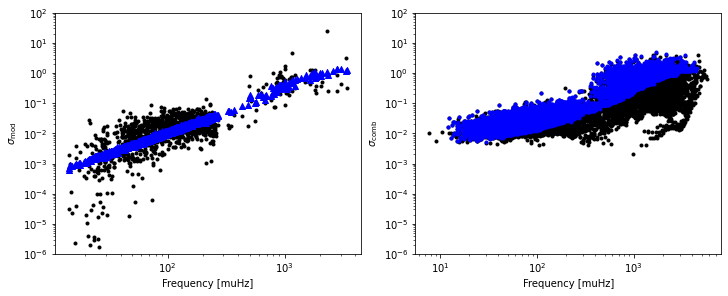

In [97]:
fig, axes = plt.subplots(figsize=(10,4), nrows=1, ncols=2, squeeze=False, constrained_layout=True)
axes=axes.reshape(-1)

idx = stars[['rms', 'numax', 'Teff']].notna().sum(axis=1) == 3

axes[0].scatter(stars.loc[idx,'numax'], stars.loc[idx,'rms'], marker='.', c='k')
axes[0].scatter(stars.loc[idx,'numax'], stars.loc[idx,'rmsp'], marker='^', c='b')

modes['e_fc_comb'] = np.sqrt(modes['e_fc']**2.0 + modes['rmsp']**2.0)
axes[1].scatter(modes['fc'], modes['e_fc'], marker='.', c='k')
axes[1].scatter(modes['fc'], modes['e_fc_comb'], marker='.', c='b')

axes[0].set_ylabel('$\\sigma_{\\rm mod}$')
axes[1].set_ylabel('$\\sigma_{\\rm comb}$')

for iax in range(2):
    axes[iax].set_yscale('log')
    axes[iax].set_xscale('log')
    axes[iax].set_ylim(10**-6, 10**2)
    axes[iax].set_xlabel('Frequency [muHz]')

print('$\sigma_{\\rm mod}$'+' = {:0.4f} * (numax/3090)^{:0.4f} * (Teff/5777)^{:0.4f}'.format(10.0**popt[0], *popt[1:]))

# Get reliable weights between classical and seismic constraints => use cluster age spread

In [4]:
suf = '_m'
original_cols = ['star_mass', 'star_age']
to_append_cols = ['mass'+suf, 'age'+suf, ]
to_append_e_cols = ['e_'+col for col in to_append_cols]

def multi(inputs):
    istar, star = inputs
    filepath = 'results_spec_gaia_nu/{:0.0f}/summary_prob.txt'.format(star['KIC'])
    if not os.path.exists(filepath): return [np.nan]*(len(to_append_cols)*2)

    data = ascii.read(filepath, delimiter=',')
    var = list(data[original_cols][1])
    e_var = list((np.array(list(data[original_cols][2])) - np.array(list(data[original_cols][0])))/2.)
    
    return var + e_var

idx = np.isin(stars['names'], ['ngc6791', 'ngc6819'])
r=process_map(multi, stars[idx].iterrows(), total=np.sum(idx), max_workers=12)

In [102]:
stars.loc[idx,to_append_cols+to_append_e_cols] = np.array(r)

# Condense the model grid into numpy binary objects

In [5]:
grids = pd.read_csv('../hpc/coarse_v2/template/coarse_grid_input_params_v2.txt') 

In [36]:
from tqdm import tqdm
import astropy.table
from grid import get_model_Dnu
import scipy.interpolate

for i in [5]: #range(0, 9)

    start = i*1000
    end = (i+1)*1000-1 if (i+1)*1000-1 < (2**13) else 2**13
    sl = slice(start, end, 1)
    print(sl)
    
    
    def multi(inputs):
        it, track = inputs
        filepath = '../hpc/coarse_v2/pre_rgb_tip/complete_grid/index{:06.0f}.history.h5'.format(track['index'])
        if not os.path.exists(filepath): 
            return None

        cols = ['index', 'profile_number', 'flag_seismo', 
                'Yinit', 'Xinit', 'Zinit', 'fov_core', 'fov_shell', 'amlt', 
                'star_age', 'star_mass', 'luminosity', 'radius', 'Teff', 
                'log_g', 'FeH', 'delta_nu_scaling', 'numax_scaling', 'acoustic_cutoff']

        f = h5py.File(filepath, 'r')
        # print(filepath)
        cols = ['index', 'profile_number', 'flag_seismo', 
                'star_age', 'star_mass', 'luminosity', 'radius', 'Teff', 'delta_nu_scaling', 'numax_scaling', 'acoustic_cutoff', 'delta_Pg', 'log_g',
                'Yinit', 'Xinit', 'Zinit', 'center_h1', 'fov_core', 'fov_shell', 'amlt', 'FeH', 'log_LHe', 'log_Lnuc']


        atrack = Table([f[col][:] for col in cols], names=cols)
        idx = (atrack['flag_seismo']==1) & (atrack['numax_scaling']>15) & ((atrack['log_LHe']-atrack['log_Lnuc'])<-3)

        atrack = atrack[idx]
        atrack['density'] = atrack['star_mass']**0.5/atrack['radius']**-1.5
        atrack['numax'] = atrack['numax_scaling']
        atrack['Dnu'] = atrack['delta_nu_scaling']

        atrack['[M/H]'] = atrack['FeH']
        atrack['mode_l'] = np.zeros(len(atrack), dtype=object)
        atrack['mode_n'] = np.zeros(len(atrack), dtype=object)
        atrack['mode_freq_o'] = np.zeros(len(atrack), dtype=object)
        # atrack['mode_freq'] = np.zeros(len(atrack), dtype=object)
        atrack['mode_inertia'] = np.zeros(len(atrack), dtype=object)
        
        # # # replace the acoustic_cutoff from mesa with numax_scaling
        atrack['acoustic_cutoff'] = atrack['numax_scaling']
        atrack['Dnu_freq_o'] = np.zeros(len(atrack))
        atrack['eps_o'] = np.zeros(len(atrack))
        atrack['surf_corr_at_numax'] = np.zeros(len(atrack))
        # #
        for i in range(len(atrack)):
            # historyIndex = atrack[i]['index']
            profileIndex = atrack[i]['profile_number']

            numax_scaling = atrack[i]['numax_scaling']
            g = atrack[i]['star_mass']/atrack[i]['radius']**2.0
            Teff = atrack[i]['Teff']
            feh = atrack[i]['FeH']
            
            atrack['mode_l'][i] = f['profile{:0.0f}/{:s}'.format(profileIndex, 'l')][:][0]
            atrack['mode_n'][i] = f['profile{:0.0f}/{:s}'.format(profileIndex, 'n_pg')][:][0]
            mode_freq = f['profile{:0.0f}/{:s}'.format(profileIndex, 'freq')][:][0]
            mode_inertia = f['profile{:0.0f}/{:s}'.format(profileIndex, 'E_norm')][:][0]
            
            atrack['Dnu_freq_o'][i], atrack['eps_o'][i] = get_model_Dnu(mode_freq, atrack['mode_l'][i], \
                                                    atrack['delta_nu_scaling'][i], atrack['numax_scaling'][i], atrack['mode_n'][i])
            
            # thetas = np.array([-6.185296 ,  0.7798102, -4.807426 , -0.7790131, 
            #                    -7.7618823,  0.7829924, -4.3983994, -0.8528419])
                
            # D1 = thetas[0] * (g)**thetas[1] * (Teff/5777.)**thetas[2] * (thetas[3]*feh + 1) # surf corr at numax
            # D2 = thetas[4] * (g)**thetas[5] * (Teff/5777.)**thetas[6] * (thetas[7]*feh + 1) # surf corr at scale*numax
            # scale = 1.1

            # fi = scipy.interpolate.interp1d(mode_freq, (mode_freq/numax_scaling)**3.0/mode_inertia, kind='cubic')
            # gs = fi(numax_scaling)

            # fi = scipy.interpolate.interp1d(mode_freq, (mode_freq/numax_scaling)**-1.0/mode_inertia, kind='cubic')
            # fs = fi(numax_scaling)

            # surface_a3 = (scale**-1 * D1 - D2)/ ((scale**-1 - scale**3) *gs)
            # surface_a1 = (scale**3 * D1 - D2)/ ((scale**3 - scale**-1) *fs)
            # dfreq = (surface_a3 *(mode_freq/numax_scaling)**3.0+surface_a1 *(mode_freq/numax_scaling)**-1.0)/mode_inertia
            
            atrack['mode_freq_o'][i] = mode_freq
            # atrack['mode_freq'][i] = mode_freq + dfreq
            atrack['mode_inertia'][i] = mode_inertia
            # atrack['surf_corr_at_numax'][i] = D1
            
        return atrack
    

    tracks = process_map(multi, grids.loc[sl,:].iterrows(), total=1000, max_workers=12)
    data = astropy.table.vstack([track for track in tracks if track is not None])
    np.save('tracks_{:0.0f}_{:0.0f}'.format(sl.start, sl.stop), data)


slice(5000, 5999, 1)


  0%|          | 0/1000 [00:00<?, ?it/s]

# Gather all eligible stellar models

In [4]:
# load in all models first
files = ['models/uncalibrated/'+f for f in os.listdir('models/uncalibrated/') if f.endswith('.npy')]
models = pd.concat([pd.DataFrame(np.load(file, allow_pickle=True)) for file in files], ignore_index=True)

In [5]:
# set index to enable fast lookup
models = models.set_index(['index', 'profile_number'])

In [6]:
models.head()

flag_seismo      star_age  star_mass  luminosity  \
index  profile_number                                                     
1000.0 1.0                       1  1.786949e+07    1.00542    2.175963   
       2.0                       1  1.962820e+07    1.00542    2.176616   
       3.0                       1  2.731025e+07    1.00542    2.185440   
       4.0                       1  4.058484e+07    1.00542    2.196096   
       5.0                       1  7.441280e+07    1.00542    2.214475   

                         radius         Teff  delta_nu_scaling  numax_scaling  \
index  profile_number                                                           
1000.0 1.0             0.948599  7197.772356        146.624008    3093.091484   
       2.0             0.948576  7198.398156        146.629241    3093.104236   
       3.0             0.949967  7200.405770        146.307329    3083.623359   
       4.0             0.951873  7201.947732        145.868255    3070.961971   
       5.0             0.954913  7205.471975        145.172250    3050.693896   

                       acoustic_cutoff  delta_Pg  ...        numax  \
index  profile_number                             ...                
1000.0 1.0                 3093.091484       0.0  ...  3093.091484   
       2.0                 3093.104236       0.0  ...  3093.104236   
       3.0                 3083.623359       0.0  ...  3083.623359   
       4.0                 3070.961971       0.0  ...  3070.961971   
       5.0                 3050.693896       0.0  ...  3050.693896   

                              Dnu     [M/H]  \
index  profile_number                         
1000.0 1.0             146.624008 -0.815818   
       2.0             146.629241 -0.815818   
       3.0             146.307329 -0.815818   
       4.0             145.868255 -0.815818   
       5.0             145.172250 -0.815818   

                                                                  mode_l  \
index  profile_number                                                      
1000.0 1.0             [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
       2.0             [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
       3.0             [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
       4.0             [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
       5.0             [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                                  mode_n  \
index  profile_number                                                      
1000.0 1.0             [7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, ...   
       2.0             [7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, ...   
       3.0             [7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, ...   
       4.0             [7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, ...   
       5.0             [7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, ...   

                                                             mode_freq_o  \
index  profile_number                                                      
1000.0 1.0             [1100.753830979918, 1238.980728433309, 1374.72...   
       2.0             [1100.724033290274, 1238.948826705201, 1374.68...   
       3.0             [1097.991122198522, 1235.871166808902, 1371.27...   
       4.0             [1094.412496073722, 1231.833009741843, 1366.78...   
       5.0             [1088.604245572801, 1225.286151928095, 1359.52...   

                                                            mode_inertia  \
index  profile_number                                                      
1000.0 1.0             [1.398447033465385e-07, 6.947345547008698e-08,...   
       2.0             [1.394039553554768e-07, 6.927908796998165e-08,...   
       3.0             [1.371867860798401e-07, 6.828661820232433e-08,...   
       4.0             [1.350374632402743e-07, 6.732201561357885e-08,...   
       5.0             [1.309061196545163e-07, 6.5487

In [69]:
popt

array([0.13286876, 1.23770111, 3.22930465])

In [7]:
# gather the data into a gigantic array

Nmodels_max = 1500

def multi(inputs):
    istar, star = inputs

    filepath = 'results_spec_gaia_nu/{:0.0f}/data.h5'.format(star['KIC'])
    if not os.path.exists(filepath): return None

    # observations
    idx = (modes['KIC']==star['KIC']) & (modes['l']==0)
    Nmodes = np.sum(idx)
    obs_freq = np.array(modes.loc[idx, 'fc'])
    obs_efreq = np.array(modes.loc[idx, 'e_fc']) 
    obs_l = np.array(modes.loc[idx, 'l']) 

    a, b, c = [0.13286876, 1.23770111, 3.22930465]
    mod_efreq_sys = 10.0**a * (star['numax']/3090)**b * (star['Teff']/5777)**c
    
    # models
    data = h5py.File(filepath, 'r')

    idx = (data['surf_corr_at_numax'][:]<0) & (np.abs(data['Dnu_freq'][:]/star['Dnu']-1)<0.15) \
             & (np.abs(data['numax_scaling'][:]/star['numax']-1)<0.15) & (data['surf_a3'][:]<0) 

    # begin reduced selection
    if np.sum(idx) > Nmodels_max:
        uidx = idx & (data['chi2_seismic_l0'][:]<np.percentile(data['chi2_seismic_l0'][idx], Nmodels_max/np.sum(idx)*100))
    else:
        uidx = idx & (data['chi2_seismic_l0'][:]<np.percentile(data['chi2_seismic_l0'][idx],100))
    idx = uidx
    # end reduced selection

    Nmodels = np.sum(idx)
    g = data['star_mass'][idx]/data['radius'][idx]**2.0
    Teff = data['Teff'][idx]
    feh = data['FeH'][idx]
    chi2_nonseis = data['chi2_classical'][idx]
    chi2 = data['chi2'][idx]

    numax_scaling = data['numax_scaling'][idx]
    numax_obs = np.zeros(np.sum(idx))+star['numax']

    Dnu_freq = data['Dnu_freq'][idx]

    Yinit = data['Yinit'][idx] 
    amlt = data['amlt'][idx]
    fov_core = data['fov_core'][idx] 
    fov_shell = data['fov_shell'][idx]
    
    mod_freqs = np.zeros((Nmodels, Nmodes))
    mod_inertias = np.zeros((Nmodels, Nmodes))
    
    indices = data['index'][idx]
    profiles = data['profile_number'][idx]

    for imod in range(Nmodels):
        if (indices[imod], profiles[imod]) in models.index :
            model = models.loc[(indices[imod], profiles[imod])]

            mod_freq = model['mode_freq_o']
            mod_l = model['mode_l']
            mod_inertia = model['mode_inertia']

            _, _, _, mode_freq_matched, mode_l_matched, mode_inertia_matched = match_modes(obs_freq, obs_efreq, obs_l, mod_freq, mod_l, mod_inertia)

            mod_freqs[imod, :] = mode_freq_matched
            mod_inertias[imod, :] = mode_inertia_matched
    
    idx = mod_freqs[:, 0] != 0
    Nmodels = np.sum(idx)
    
    # print('Processing KIC {:09.0f}, Nmodel: {:0.0f}'.format(star['KIC'], np.sum(idx)))

    datacube = {'istar':istar, 'KIC':star['KIC'], 'Nmodels':Nmodels, 
                'Nmodes':Nmodes, 'mod_efreq_sys':mod_efreq_sys,
                'obs_freq':obs_freq, 'obs_efreq':obs_efreq,
                'g':g[idx], 'Teff':Teff[idx], 'feh':feh[idx], 'chi2_nonseis':chi2_nonseis[idx], 'chi2':chi2[idx],
                'numax_obs':numax_obs[idx], 'numax_scaling':numax_scaling[idx], 
                'Dnu_freq':Dnu_freq[idx], 
                'Yinit':Yinit[idx], 'amlt':amlt[idx], 'fov_core':fov_core[idx], 'fov_shell':fov_shell[idx],
                'mod_freqs':mod_freqs[idx,:], 'mod_inertias':mod_inertias[idx,:]}
    return datacube 

sel = ~np.isin(stars['names'], ['ngc6791', 'ngc6819', 'binary'])
r=process_map(multi, stars.loc[sel,:].iterrows(), total=np.sum(sel), max_workers=16)
r = np.array(r, dtype=object) 
data_to_save = r[~(r == None)]

np.save('data/stellar_models_for_surface_optimisation', data_to_save)

  0%|          | 0/1239 [00:00<?, ?it/s]

In [8]:
stardata = np.load('data/stellar_models_for_surface_optimisation.npy', allow_pickle=True)

In [11]:
Nmodels_star

array([949, 234, 172, ..., 275, 420, 228])

(array([ 58., 442., 367., 154.,  86.,  26.,  17.,   7.,   7.,  23.]),
 array([   3. ,  152.7,  302.4,  452.1,  601.8,  751.5,  901.2, 1050.9,
        1200.6, 1350.3, 1500. ]),
 <BarContainer object of 10 artists>)

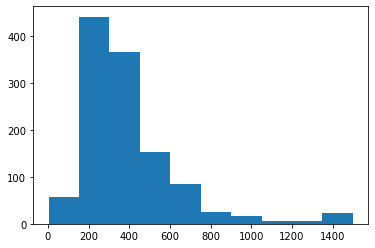

In [10]:
Nmodels_star = np.array([stardata[istar]['Nmodels'] for istar in range(len(stardata))])
kics = np.array([stardata[istar]['KIC'] for istar in range(len(stardata))])
plt.hist(Nmodels_star)

(7000.0, 4000.0)

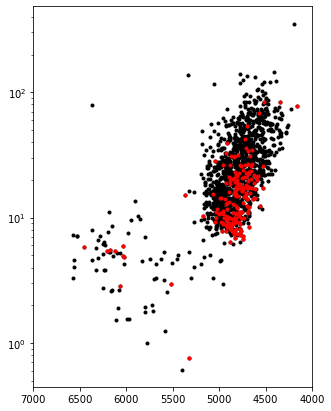

In [83]:
plt.figure(figsize=(5,7))
plt.plot(stars['Teff'], stars['lum_J'], 'k.')
idx = np.isin(stars['KIC'], kics[Nmodels_star < 200])
plt.plot(stars.loc[idx,'Teff'], stars.loc[idx,'lum_J'], 'r.')
plt.yscale('log')
plt.xlim(7000, 4000)